In [ ]:
!pip3 install transformers
!pip3 install nltk
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.3 MB/s 
     |████████████████████████████████| 596 kB 74.7 MB/s 
     |████████████████████████████████| 895 kB 60.7 MB/s 
     |████████████████████████████████| 61 kB 461 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hate.csv')
dataset.dropna(inplace = True)
df = dataset
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()

number of tweets belonging to classes 0,1 and 2


class
0     1430
1    19190
2     4163
Name: id, dtype: int64

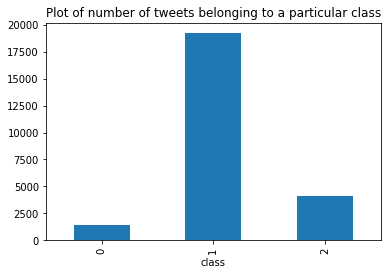

In [ ]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

Data Cleaning

In [ ]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words= set(stopwords.words('english'))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)

In [ ]:
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,"[rt, mayasolovely, woman, complain, cleaning, ..."
1,1,3,0,3,0,1,"[rt, mleew, boy, dats, cold, tyga, dwn, bad, c..."
2,2,3,0,3,0,1,"[rt, urkindofbrand, dawg, rt, sbaby, life, eve..."
3,3,3,0,2,1,1,"[rt, c, g, anderson, viva, based, look, like, ..."
4,4,6,0,6,0,1,"[rt, shenikaroberts, shit, hear, might, true, ..."
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,"[muthaf, lie, lifeasking, pearls, corey, emanu..."
24779,25292,3,0,1,2,2,"[gone, broke, wrong, heart, baby, drove, redne..."
24780,25294,3,0,3,0,1,"[young, buck, wan, na, eat, dat, nigguh, like,..."
24781,25295,6,0,6,0,1,"[youu, got, wild, bitches, tellin, lies]"


Word2Vec model to get the word embedings.

In [ ]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [ ]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)

In [ ]:
dataset["features"]=dataset["tweet"].apply(get_features)

In [ ]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [ ]:
data

array([[-0.31733868,  0.3248959 ,  0.02550528, ..., -0.93202263,
         1.6183944 ,  0.05676062],
       [-0.20634589,  0.2344357 ,  0.02529181, ..., -0.6194882 ,
         1.1225741 ,  0.04505901],
       [-0.29148942,  0.34359008,  0.03427425, ..., -0.8745503 ,
         1.5796204 ,  0.0700067 ],
       ...,
       [-0.10792682,  0.38193476,  0.03961182, ..., -0.8905783 ,
         1.5095992 , -0.03411246],
       [-0.1657636 ,  0.21519955,  0.04531204, ..., -0.5220664 ,
         1.0574765 ,  0.00259172],
       [-0.18925929,  0.16201971,  0.01684322, ..., -0.50373995,
         0.84975004,  0.04027721]], dtype=float32)

In [ ]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [ ]:
n_classes

3

In [ ]:
print(X_train)
print(y_train)

[[-0.22927976  0.23059198  0.01919868 ... -0.6559493   1.1399835
   0.04831881]
 [-0.2915773   0.26861888  0.02178178 ... -0.7755815   1.346934
   0.05648156]
 [-0.22626944  0.2448772   0.02488492 ... -0.62226576  1.1436836
   0.06365318]
 ...
 [-0.1867713   0.15120375 -0.01318096 ... -0.5214283   0.8485402
   0.02140096]
 [-0.18656407  0.18293828  0.02125181 ... -0.5206288   0.8991294
   0.05213764]
 [-0.28862736  0.37162954  0.05111507 ... -0.891178    1.6750625
   0.04313806]]
[[1 0 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


LOGISTIC REGRESSION MODEL

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

F1 Score:  0.8367958656330748
Precision Score:  0.8579906740144129
Recall Score:  0.8166229574339318
Accuracy:  0.8156142828323583


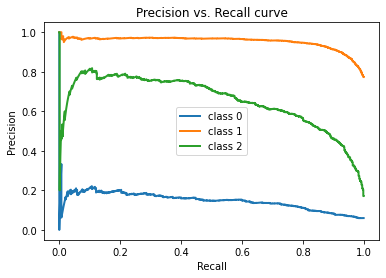

In [ ]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

In [ ]:
print(precision)

{0: array([0.05994212, 0.05974778, 0.05976013, ..., 0.        , 0.        ,
       1.        ]), 1: array([0.77304821, 0.77300242, 0.77315843, ..., 1.        , 1.        ,
       1.        ]), 2: array([0.17131719, 0.17114714, 0.17118227, ..., 0.5       , 1.        ,
       1.        ])}


SVM MODEL


F1 Score:  0.7991239048811013
Precision Score:  0.8272511336644354
Recall Score:  0.7728464797256405
Accuracy:  0.7728464797256405


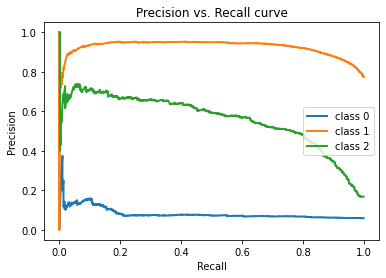

In [ ]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()